# 1 Corpus beschaffen importieren


In [27]:
TafsirId = 9
Sura = 1
Aya = 6

In [28]:
import create_record as cr
import pandas as pd

corpus = pd.Series({}, dtype="object")

In [29]:
temp = cr.altafsir_extractor(TafsirId, Sura, Aya)
temp.collect_data()
corpus["Text"] = temp.Text

# 2 Preprocessing
## 2.1 Normalizing data

In [30]:
from camel_tools.utils.normalize import normalize_unicode
from camel_tools.utils.normalize import normalize_alef_maksura_ar
from camel_tools.utils.normalize import normalize_alef_ar
from camel_tools.utils.normalize import normalize_teh_marbuta_ar
from camel_tools.utils.dediac import dediac_ar


def reduce_to_archarset(text):
    import re
    # Remove non-arabic characters
    nonarab_chars = '[^\u0621-\u064A ]'
    text = re.sub(nonarab_chars, '', text)
    return text

def remove_eulogies(text):
    import re
    
    with open("./assets/eulogies.txt", encoding="utf-8") as f:
        eulogies = f.read().splitlines()
    for eulogy in eulogies:
        text = re.sub(eulogy, '', text)
    return text

def remove_ref(text):
    import re
    # Remove reference to other ayas
    ref = '\[(.*?)\]'
    text = re.sub(ref, '', text)
    return text


## normalize
def normalizer(string):
    string_normalized = normalize_unicode(string)

    # remove diacritica
    string_normalized = dediac_ar(string_normalized)
    
    string_normalized = remove_ref(string_normalized)
    string_normalized = remove_eulogies(string_normalized)
    

    #reduce to arabic charset
    string_normalized = reduce_to_archarset(string_normalized)
    return string_normalized



In [31]:
corpus["TextNormalized"] = normalizer(corpus["Text"])

## 2.2 NER

In [32]:
from camel_tools.tokenizers.word import simple_word_tokenize
from camel_tools.ner import NERecognizer

ner = NERecognizer.pretrained()

# NERecognizer expects pre-tokenized text
sentence = simple_word_tokenize(corpus["TextNormalized"])

labels = ner.predict_sentence(sentence)

# save each token paired with it's NER label
zipped = list(zip(sentence, labels))

In [33]:
# Filter and glue named entities into dictionary
named_entities = {"LOC" : [], "ORG" : [], "PERS" : [], "MISC" : []}
for i, val in enumerate(zipped):
    if zipped[i][1][0] == "B":
        named_entities[zipped[i][1][2:]].append(zipped[i][0])
    if zipped[i][1][0] == "I":
        named_entities[zipped[i][1][2:]][-1] = named_entities[zipped[i][1][2:]][-1] + " " + zipped[i][0]
named_entities["PERS"]

['لحمد لله',
 'ابن جرير',
 'ابن كثير',
 'ابن جرير',
 'ابن أبي حاتم',
 'ابن عباس',
 'عمر',
 'علي',
 'ابن أبي حاتم',
 'ابن عباس',
 'عبدي',
 'وابن جرير',
 'ابن عباس',
 'ابن جرير',
 'الحكم بن عمير',
 'عبد الرزاق',
 'والحكيم',
 'الترمذي',
 'والخطابي',
 'والبيهقي',
 'والديلمي',
 'عبد الله بن عمرو بن العاص',
 'ابن المنذر',
 'وابن أبي حاتم',
 'أبي عبد الرحمن الحبلي',
 'الطبراني',
 'النواس بن سمعان',
 'أحمد',
 'والنسائي',
 'والحاكم',
 'والبخاري',
 'الأسود بن سريع',
 'الترمذي',
 'والنسائي',
 'ماجه',
 'وابن حبان',
 'والبيهقي',
 'جابر',
 'ابن ماجه',
 'والبيهقي',
 'أنس',
 'عبد',
 'الحكيم الترمذي',
 'والقرطبي',
 'أنس',
 'القرطبي',
 'البيهقي',
 'جابر',
 'عبد الرزاق',
 'الحسن',
 'مسلم',
 'والنسائي',
 'وأحمد',
 'أبي مالك الأشعري',
 'سعيد بن منصور',
 'وأحمد',
 'والترمذي',
 'وحسنه',
 'وابن مردويه',
 'الحكيم الترمذي',
 'عبد الله بن عمر',
 'البيهقي',
 'أنس',
 'ابن شاهين',
 'والديلمي',
 'أبان بن أنس',
 'وابن حبان',
 'والبيهقي',
 'أبي هريرة',
 'ابن ماجه',
 'ابن عمر',
 'عبدا',
 'عبده',
 'عبدي',
 'عبدي',
 'مسل

In [34]:
from camel_tools.disambig.mle import MLEDisambiguator
from camel_tools.tokenizers.morphological import MorphologicalTokenizer

from camel_tools.tokenizers.word import simple_word_tokenize


# Load a pretrained disambiguator to use with a tokenizer
mle = MLEDisambiguator.pretrained('calima-msa-r13')

# `split=True`: morphological tokens are output as seperate strings.
tokenizer = MorphologicalTokenizer(mle, scheme='d3tok', split=True)
named_entities["Morphed"] = tokenizer.tokenize(named_entities["PERS"])

# Rausfiltern unselbständiger Morpheme
named_entities["Morphed"] = [token for token in named_entities["Morphed"] if not '+' in token]


## 2.4 Create Frequency Analysis

In [35]:
from collections import Counter

from arabic_reshaper import reshape      # pip install arabic-reshaper
from bidi.algorithm import get_display   # pip install python-bidi

rtl = lambda w: get_display(reshape(f'{w}'))

COUNTS = Counter(named_entities["Morphed"])
counts = {rtl(k):v for k, v in COUNTS.most_common(40)}

In [36]:
counts

{'ﺱﺎﺒﻋ ﻦﺑﺍ': 15,
 'ﺮﻳﺮﺟ ﻦﺑﺍ': 13,
 'ﺪﻴﻤﺣ ﻦﺑ ﺪﺒﻋﻭ': 11,
 'ﺪﻤﺣﺃ': 10,
 'ﻲﺒﻃﺮﻗ': 10,
 'ﺮﻳﺮﺟ ﻦﺑﺍﻭ': 9,
 'ﻱﺬﻣﺮﺗ': 9,
 'ﻢﻛﺎﺣ': 9,
 'ﺭﺬﻨﻤﻟﺍ ﻦﺑﺍﻭ': 9,
 'ﻲﻘﻬﻴﺒﻟﺍﻭ': 8,
 'ﺮﻴﺜﻛ ﻦﺑﺍ': 7,
 'ﻢﺗﺎﺣ ﻲﺑﺃ ﻦﺑﺍﻭ': 7,
 'ﺲﻧﺃ': 7,
 'ﺓﺮﻳﺮﻫ ﻲﺑﺃ': 7,
 'ﻲﺋﺎﺴﻧ': 6,
 'ﻦﺴﺣ': 6,
 'ﻲﻧﺍﺮﺒﻄﻟﺍ': 5,
 'ﺪﻴﻤﺣ ﻦﺑ ﺪﺒﻋ': 5,
 'ﻚﻟﺎﻣ': 5,
 'ﻊﻴﻛﻭ': 5,
 'ﺩﻭﺍﺩ ﻮﺑﺃﻭ': 5,
 'ﻱﺪﺒﻋ': 4,
 'ﻕﺍﺯﺮﻟﺍ ﺪﺒﻋ': 4,
 'ﻥﺎﺒﺣ ﻦﺑﺍﻭ': 4,
 'ﻪﺟﺎﻣ ﻦﺑﺍ': 4,
 'ﻢﻠﺴﻣ': 4,
 'ﺩﻮﻌﺴﻣ ﻦﺑﺍ': 4,
 'ﻖﻴﻘﺷ ﻦﺑ ﷲ ﺪﺒﻋ': 4,
 'ﺔﺒﻴﺷ ﻲﺑﺃ ﻦﺑﺍﻭ': 4,
 'ﻢﺗﺎﺣ ﻲﺑﺃ ﻦﺑﺍ': 3,
 'ﺮﻤﻋ': 3,
 'ﻱﺭﺎﺨﺑ': 3,
 'ﺪﺒﻋ': 3,
 'ﻲﻘﻬﻴﺒﻟﺍ': 3,
 'ﺭﻮﺼﻨﻣ ﻦﺑ ﺪﻴﻌﺳ': 3,
 'ﻦﻤﺣﺭ': 3,
 'ﺩﺎﺘﻗ': 3,
 'ﻱﺭﺎﺒﻧﻷﺍ ﻦﺑﺍ': 3,
 'ﻪﺟﺎﻣ ﻦﺑﺍﻭ': 3,
 'ﻰﻠﻋ': 2}

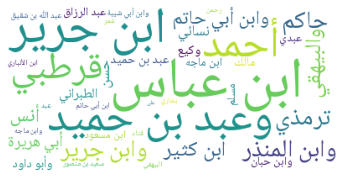

In [37]:
from wordcloud import WordCloud          # pip install wordcloud
import matplotlib.pyplot as plt
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'


font_file = './assets/NotoNaskhArabic-Regular.ttf'
wordcloud = WordCloud(font_path=font_file, background_color="white").generate_from_frequencies(counts)
wordcloud.to_file(f"./assets/wc_names_{TafsirId}_{Sura}_{Aya}.png")
plt.imshow(wordcloud)
plt.axis("off")
plt.show()